In [2]:
from datetime import timedelta
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import keyboard

In [3]:
def format_timedelta(td):
    result= str(td)
    try:
        result,ms = result.split(".")
    except ValueError:
        return (result+".00").replace(":","-")
    ms = int(ms)
    ms = round(ms/1e4)
    
    return f"{result}.{ms:02}".replace(":","-")



def get_saving_frames_durations(cap, saving_fps):
    
    """
    A function that returns the list of durations where to save the frames
    """
    
    s = []
    
    # get the clip duration by dividing number of frames by the number of frames per second
    clip_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    
    # use np.arange() to make floating-point steps
    for i in np.arange(0, clip_duration, 1 / saving_fps):
        s.append(i)
    
    return s

def read_images(video_file, SAVING_FRAMES_PER_SECOND):
    
    frames=[]
    
    filename, _ = os.path.splitext(video_file)
    filename += "-opencv"
    
    # make a folder by the name of the video file
    if not os.path.isdir(filename):
        os.mkdir(filename)
        
    # read the video file    
    cap = cv2.VideoCapture(video_file)
    
    
    # get the FPS of the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # if the SAVING_FRAMES_PER_SECOND is above video FPS, then set it to FPS (as maximum)
    saving_frames_per_second = min(fps, SAVING_FRAMES_PER_SECOND)
    
    # get the list of duration spots to save
    saving_frames_durations = get_saving_frames_durations(cap, saving_frames_per_second)
    # start the loop
    count = 0
    
    while True:
        is_read, frame = cap.read()
        

        if not is_read:
            # break out of the loop if there are no frames to read
            break
        # get the duration by dividing the frame count by the FPS
        frame_duration = count / fps
        
        try:
            # get the earliest duration to save
            closest_duration = saving_frames_durations[0]
        except IndexError:
            # the list is empty, all duration frames were saved
            break
        
        if frame_duration >= closest_duration:
            # if closest duration is less than or equals the frame duration, 
            # then save the frame
            frame_duration_formatted = format_timedelta(timedelta(seconds=frame_duration))
            
            cv2.imwrite(os.path.join(filename, f"frame{frame_duration_formatted}.jpg"), frame) 
            # drop the duration spot from the list, since this duration spot is already saved
            try:
                saving_frames_durations.pop(0)
            except IndexError:
                pass
    
        # increment the frame count
        frames.append(frame)

        count += 1
        
    return frames

In [4]:

class ClickRecorder:
    def __init__(self, image):
        self.positions = []
        self.clicks = 0
        self.fig, self.ax = plt.subplots(figsize=(20,10))
        self.ax.imshow(image)
        self.ax.set_title('Cliquez pour enregistrer les positions')
        self.cid = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        self.stop_key = 'escape'  # Touche pour arrêter l'enregistrement (ici, 'Esc')
        
    def onclick(self, event):
        self.clicks += 1
        if self.clicks <= 2:
            self.positions.append((event.xdata, event.ydata))
        if self.clicks == 2:
            self.fig.canvas.mpl_disconnect(self.cid)
            plt.close(self.fig)

    def check_stop(self, event):
        return event.key == self.stop_key

    def get_positions(self):
        if len(self.positions) >= 2:
            return self.positions[0], self.positions[1]
        else:
            return None

        
def get_angle(image):
    click_recorder = ClickRecorder(image)
    
    
    # Définir une fonction pour gérer les événements clavier
    def on_key(event):
        if click_recorder.check_stop(event):
            click_recorder.clicks = 2
            click_recorder.fig.canvas.mpl_disconnect(key_cid)
            plt.close(click_recorder.fig)

    # Connecter la fonction de gestion des événements clavier
    key_cid = click_recorder.fig.canvas.mpl_connect('key_press_event', on_key)

    plt.show()

    while not click_recorder.clicks==2:
        plt.pause(0.1)
    
    # Accès aux positions après la fermeture du graphique
    positions = click_recorder.get_positions()
    if positions is not None:
        x_a, y_a = positions[0]
        x_b, y_b = positions[1]

        angle = np.arctan((x_b-x_a)/(y_b-y_a))*180/np.pi
        return angle
    

In [5]:
%matplotlib qt

In [7]:
ws = 10
for model in ['L','R']:
    
    angles=[]

    for run in range(1,3):
        video_number = str(ws)+'ms_'+model+'11111_Run'+str(run)

        path_video = '/media/nbourg/One Touch/Bluebottle/LuminyFlumePaper/submission_MPB/revision/GoProAngleAttack/'

        video_file = path_video+video_number+'.MP4'
        save_fps = .5

        frames = np.array(read_images(video_file,save_fps))

        for i in range(0,len(frames),60):
            angles.append(get_angle(frames[i]))
    
    np.save(path_video+'npys/'+video_number[:-5]+'.npy',angles,allow_pickle=True)

In [9]:
%matplotlib inline

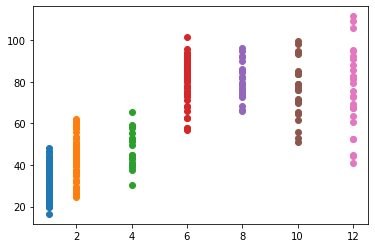

In [10]:
fig,ax=plt.subplots()
model='L'

for ws in [1,2,4,6,8,10,12]:

    video_number = str(ws)+'ms_'+model+'11111_Run1'

    path_video = '/media/nbourg/One Touch/Bluebottle/LuminyFlumePaper/submission_MPB/revision/GoProAngleAttack/'

    angle = np.load(path_video+'npys/'+video_number[:-5]+'.npy',allow_pickle=True)
    all_angle = []
    
    for a in angle:
        if a is not None:
            if a <0 :
                
                all_angle.append(a+180)
            else:
                all_angle.append(a)
    
    #ax.boxplot(all_angle,positions=[ws])
    ax.scatter(ws*np.ones(len(all_angle)), all_angle)

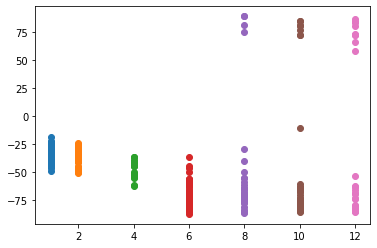

In [11]:
fig,ax=plt.subplots()
model='R'

for ws in [1,2,4,6,8,10,12]:

    video_number = str(ws)+'ms_'+model+'11111_Run1'

    path_video = '/media/nbourg/One Touch/Bluebottle/LuminyFlumePaper/submission_MPB/revision/GoProAngleAttack/'

    angle = np.load(path_video+'npys/'+video_number[:-5]+'.npy',allow_pickle=True)
    all_angle = []
    
    for a in angle:
        if a is not None:
            all_angle.append(a)
    
    #ax.boxplot(all_angle,positions=[ws])
    ax.scatter(ws*np.ones(len(all_angle)), all_angle)

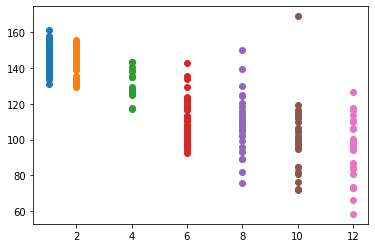

In [12]:
fig,ax=plt.subplots()
model='R'

for ws in [1,2,4,6,8,10,12]:

    video_number = str(ws)+'ms_'+model+'11111_Run1'

    path_video = '/media/nbourg/One Touch/Bluebottle/LuminyFlumePaper/submission_MPB/revision/GoProAngleAttack/'

    angle = np.load(path_video+'npys/'+video_number[:-5]+'.npy',allow_pickle=True)
    all_angle = []
    
    for a in angle:
        if a is not None:
            if a <0 :
                
                all_angle.append(a+180)
            else:
                all_angle.append(a)
    
    #ax.boxplot(all_angle,positions=[ws])
    ax.scatter(ws*np.ones(len(all_angle)), all_angle)

In [13]:
# U10 equivalents from Elpida Vonta's report
z0 = 1e-3 * np.array([0.066 - 0.3 * (0.129 - 0.066),
                     0.066,
                     0.272,
                     0.383,
                     np.mean([0.383, 0.483]),
                     0.483,
                     0.721,
                     0.721 + (0.721 - 0.483)])

ws = np.array([1, 2, 4, 6, 7, 8, 10, 12])
U10 = ws * np.log(10 / z0) / np.log(0.7 / z0)
print(U10)

[ 1.27681702  2.57378534  5.35451352  8.12434879  9.51956871 10.92273793
 13.86621703 16.84019246]


In [16]:
ws = np.array([1, 2, 4, 6, 7, 8, 10, 12])
U10 = ws * np.log(10 / z0) / np.log(0.7 / z0)
print(U10)

U102 = np.array([U10[0],U10[1],U10[2],U10[3],U10[5],U10[6],U10[7]])

[ 1.27681702  2.57378534  5.35451352  8.12434879  9.51956871 10.92273793
 13.86621703 16.84019246]


In [15]:
drift_angle = np.load('/media/nbourg/One Touch/Bluebottle/LuminyFlumePaper/submission_MPB/revision/ave_drift_angle.npy')


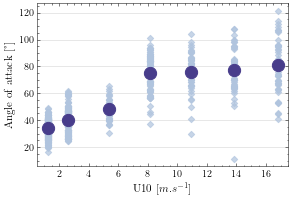

In [80]:
import scienceplots
attack_angle = np.nan*np.ones(drift_angle.shape)
plt.style.use(["science", "high-contrast"])

fig,ax=plt.subplots(figsize=(4.5,3))
ax.set_ylabel('Angle of attack [°]', fontsize=11)
ax.set_xlabel('U10 $[m.s^{-1}]$', fontsize=11)

# Add x-axis gridlines
for ws,u,idx_aa in zip([1,2,4,6,8,10,12],U102,[0,1,2,3,5,6,7]):
    model='L'
    video_number = str(ws)+'ms_'+model+'11111_Run1'

    path_video = '/media/nbourg/One Touch/Bluebottle/LuminyFlumePaper/submission_MPB/revision/GoProAngleAttack/'

    angle = np.load(path_video+'npys/'+video_number[:-5]+'.npy',allow_pickle=True)
    all_angle = []
    
    for a in angle:
        if a is not None:
            if a < 0:
                all_angle.append(180+a)
            else:
                all_angle.append(a)  
    ax.scatter(u*np.ones(len(all_angle)), (all_angle),c='lightsteelblue',s=20,alpha=.7,zorder=4,marker='D')
    model='R'
    
    video_number = str(ws)+'ms_'+model+'11111_Run1'

    path_video = '/media/nbourg/One Touch/Bluebottle/LuminyFlumePaper/submission_MPB/revision/GoProAngleAttack/'

    angle = np.load(path_video+'npys/'+video_number[:-5]+'.npy',allow_pickle=True)
    all_angle2 = []
    
    for a in angle:
        if a is not None:
            if -a < 0:
                all_angle2.append(180-a)
            else:
                
                all_angle2.append(-a)
            
    
    ax.scatter(u*np.ones(len(all_angle2)), (all_angle2),c='lightsteelblue',s=20,alpha=.7,zorder=4,marker='D')
    
    all_angles=np.concatenate([all_angle,all_angle2])
    
    attack_angle[idx_aa] = np.nanmean((all_angles))
    
    ax.scatter(u,np.nanmean((all_angles)),c='darkslateblue',s=150,alpha=1,zorder=5,marker='o')
#ax.xaxis.grid(alpha=0.6, linewidth=0.1)
ax.set_xlim(0.5, 17.5)
#ax.yaxis.grid(linestyle='--', which='minor',alpha=0.6)
ax.set_xticks([2, 4, 6, 8, 10, 12, 14, 16])
ax.yaxis.grid(zorder=0, alpha=0.6)
fig.savefig('FIG_AngleAttacknoNeg.png', dpi=500, facecolor='w',bbox_inches='tight')


In [18]:
drift_angle

array([41.32291875, 32.32234702, 25.60774221, 15.08779251,  8.92630903,
        6.00140659,  6.13970287,  4.94444269])

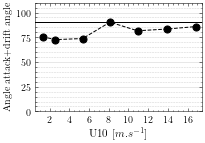

In [19]:
fig,ax=plt.subplots(figsize=(3,2))
ax.set_ylim(0,110)
ax.axhline(90,c='k')
ax.set_xlim(0.5, 17.5)
ax.yaxis.grid(zorder=0, alpha=0.6,which='major')
ax.yaxis.grid(zorder=0, alpha=0.6,which='minor',linestyle='--')

ax.set_xticks([2, 4, 6, 8, 10, 12, 14, 16])
ax.set_ylabel('Angle attack+drift angle')
ax.scatter(U10,attack_angle+drift_angle,c='k',zorder=5,s=50)
ax.plot(U10[~np.isnan(attack_angle)],
        attack_angle[~np.isnan(attack_angle)]+drift_angle[~np.isnan(attack_angle)],c='k',linestyle='--')

ax.set_xlabel('U10 $[m.s^{-1}]$', fontsize=11)
fig.savefig('FIG_AngleAttack+DriftAngleNoNeg.png', dpi=500, facecolor='w',bbox_inches='tight')


In [ ]:
90-15

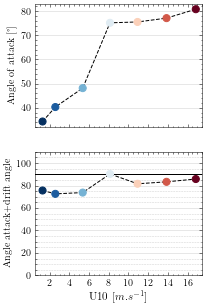

In [20]:
fig,ax=plt.subplots(figsize=(3,5),nrows=2,sharex=True)

ax[0].scatter(U10,attack_angle,c=U10,cmap='RdBu_r',zorder=5,s=50)
ax[0].plot(U10[~np.isnan(attack_angle)],
        attack_angle[~np.isnan(attack_angle)],c='k',linestyle='--')
ax[0].set_ylabel('Angle of attack [°]')
#ax[0].set_ylim(15,65)
ax[0].yaxis.grid(zorder=0, alpha=0.6,which='major')

ax[1].set_ylim(0,110)
ax[1].axhline(90,c='k')
ax[1].set_xlim(0.5, 17.5)
ax[1].yaxis.grid(zorder=0, alpha=0.6,which='major')
ax[1].yaxis.grid(zorder=0, alpha=0.6,which='minor',linestyle='--')

ax[1].set_xticks([2, 4, 6, 8, 10, 12, 14, 16])
ax[1].set_ylabel('Angle attack+drift angle')
ax[1].scatter(U10,attack_angle+drift_angle,c=U10,cmap='RdBu_r',zorder=5,s=50)
ax[1].plot(U10[~np.isnan(attack_angle)],
        attack_angle[~np.isnan(attack_angle)]+drift_angle[~np.isnan(attack_angle)],c='k',linestyle='--')

ax[1].set_xlabel('U10 $[m.s^{-1}]$', fontsize=11)
fig.savefig('FIG2_AngleAttack+DriftAngleNoNeg.png', dpi=500, facecolor='w',bbox_inches='tight')


In [25]:

cmaplines  = 'RdPu'
model = '11111'
cmaprdpu = cmap= plt.get_cmap(cmaplines)
col = [cmaprdpu(u / 17) for u in U10]
col

[(0.9953248750480584, 0.9148635140330642, 0.9015148019992311, 1.0),
 (0.9914033064206075, 0.8580853517877739, 0.8448135332564398, 1.0),
 (0.9842368319876971, 0.6965782391387928, 0.7309496347558632, 1.0),
 (0.9706574394463667, 0.4450595924644368, 0.6449058054594388, 1.0),
 (0.9190465205690119, 0.3086812764321415, 0.6123029603998462, 1.0),
 (0.8399231064975011, 0.17490196078431391, 0.577931564782776, 1.0),
 (0.5751941560938101, 0.00392156862745098, 0.47969242599000383, 1.0),
 (0.2983314109957709, 0.00024605920799692423, 0.41888504421376394, 1.0)]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

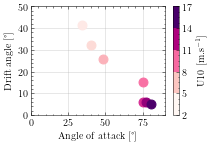

In [37]:
import matplotlib as mpl

plt.style.use(["science", "high-contrast"])
fig,ax=plt.subplots(figsize=(3,2))
ax.set_facecolor('w')
ax.yaxis.grid(zorder=0, alpha=0.6,which='major')
ax.xaxis.grid(zorder=0, alpha=0.6,which='major')
ax.set_xlim(0,90)
ax.set_ylim(0,50)
ax.set_xlabel('Angle of attack [°]')
ax.set_ylabel('Drift angle [°]')
for a,d,c in zip(attack_angle,drift_angle,col):
    ax.scatter(a,d,c=c,s=80,zorder=5)
bounds = [2, 5, 8, 11, 14, 17]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmaplines, norm=norm)

fig.colorbar(sm,label='U10 [m.s$^{-1}$]')
fig.savefig('FIG_AngleAttackvsDriftAngleNoNeg.png', dpi=500, facecolor='w',bbox_inches='tight')



plt.style.use(["science", "high-contrast"])
fig,ax=plt.subplots(figsize=(3,2))
ax.yaxis.grid(zorder=0, alpha=0.6,which='major')
ax.xaxis.grid(zorder=0, alpha=0.6,which='major')
ax.set_ylim(15,65)
ax.set_xlim(0,40)
ax.set_ylabel('Angle of attack [°]')
ax.set_xlabel('Drift angle [°]')
sc=ax.scatter(drift_angle,attack_angle,c=U10,s=80,zorder=5,cmap='RdBu_r')
fig.colorbar(sc,label='U10 m.s$^{-1}$')
fig.savefig('FIG_DriftAnglevsAngleAttack.png', dpi=500, facecolor='w',bbox_inches='tight')
